In [1]:
import tensorflow as tf
import pickle
import numpy as np
import timeit, time
import load_cifar
import matplotlib.pyplot as plt

In [51]:
tf.reset_default_graph()

<h1>Define Hyper-perparmeter</h1>

In [52]:
filePath = '/home/lkumari/data/cifar-10-batches-py/'

In [53]:
EPOCHS = 30
BATCH_SIZE = 128
# lr = 0.001
# keep_proba = 0.8

feature_dim = 3072
hidden_1 = 1000
hidden_2 = 100
num_classes = 10
num_batches = 5

def learning_rate_schedule(epoch_num):
    if epoch_num < 10:
        return 0.001
    else:
        return 0.0001

<h1>Define Placeholder</h1>

In [54]:
X = tf.placeholder(tf.float32, [None, 3072], name='X')
Y =  tf.placeholder(tf.int32, [None, 10], name='Y')
# keep_prob = tf.placeholder(tf.float32, name='keep_prob')
lr = tf.placeholder(tf.float32)

<h1>Define Neural Network Architecture</h1>

In [55]:
def Model(x):
    # FC layer 1
    with tf.name_scope('fc_1') as scope:
        weights = tf.get_variable(name='W_fc1', shape=[feature_dim, hidden_1], 
                                 initializer=tf.truncated_normal_initializer(mean=0.0, stddev=1.0/np.sqrt(float(feature_dim))))

        biases = tf.Variable(tf.zeros([hidden_1]), name='b_fc1')
        fc_1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(x, weights), biases), name=scope)
   
    # FC layer 2    
    with tf.name_scope('fc_2') as scope:
        weights = tf.get_variable(name='W_fc2', shape=[hidden_1, hidden_2], 
                                 initializer=tf.truncated_normal_initializer(mean=0.0, stddev=1.0/np.sqrt(float(hidden_1))))

        biases = tf.Variable(tf.zeros([hidden_2]), name='b_fc2')
        fc_2 = tf.nn.relu(tf.nn.bias_add(tf.matmul(fc_1, weights), biases), name=scope)
        
    # FC layer 3
    with tf.name_scope('out') as scope:
        weights = tf.get_variable(name='W_out', shape=[hidden_2, num_classes], 
                                 initializer=tf.truncated_normal_initializer(mean=0.0, stddev=1.0/np.sqrt(float(hidden_2))))

        biases = tf.Variable(tf.zeros([num_classes]), name='b_out')
        out = tf.nn.bias_add(tf.matmul(fc_2, weights), biases, name=scope)
     
    return out      

<h1>Define cost andoptimization</h1>

In [56]:
#predicted labels
logits = Model(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

#Initialize the variables
init = tf.global_variables_initializer()

<h1>Training and testing</h1>
<h2>1.Print out validation accuracy after each training poch</h2>
<h2>2.Print out training time you spend on each epoch</h2>
<h2>3.Print out testing accuracy in the end</h2>

In [57]:
val_accuracy = []
test_accuracy = []
time_taken = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(init)
    
    for ep in range(EPOCHS):
        l_rate = learning_rate_schedule(ep)
        start_time = time.time()
        for batch_num in range(1, num_batches+1):
            for batch_features, batch_labels in load_cifar.load_preprocessed_training_batch(batch_num, BATCH_SIZE):
                train_loss, acc, _ = sess.run(fetches=[loss, accuracy, train_op], feed_dict={X: batch_features, Y: batch_labels, lr: l_rate})
        end_time = time.time()
        time_s = end_time - start_time
        
        val_features, val_labels = load_cifar.load_preprocessed_validation_batch()
        val_acc = sess.run(fetches=[accuracy], feed_dict={X: val_features, Y: val_labels})

        test_features, test_labels = load_cifar.load_preprocessed_test()
        test_acc = sess.run(fetches=[accuracy], feed_dict={X:test_features, Y:test_labels})
        
        val_accuracy.append(val_acc[0])
        test_accuracy.append(test_acc[0])
        time_taken.append(time_s)
                
        print("Epoch {}: training loss = {}, training_time = {}, val_accuracy = {}, test_accuracy = {}".format(
            ep, train_loss, time_s, val_acc[0], test_acc[0]))             

Epoch 0: training loss = 2.0895016193389893, training_time = 3.9597840309143066, val_accuracy = 0.3776000142097473, test_accuracy = 0.3776000142097473
Epoch 1: training loss = 1.9739360809326172, training_time = 3.7712228298187256, val_accuracy = 0.40619999170303345, test_accuracy = 0.4036000072956085
Epoch 2: training loss = 1.9350334405899048, training_time = 3.7006280422210693, val_accuracy = 0.40700000524520874, test_accuracy = 0.41839998960494995
Epoch 3: training loss = 1.7886626720428467, training_time = 3.658998489379883, val_accuracy = 0.4472000002861023, test_accuracy = 0.45260000228881836
Epoch 4: training loss = 1.7610957622528076, training_time = 3.690025568008423, val_accuracy = 0.46480000019073486, test_accuracy = 0.4652000069618225
Epoch 5: training loss = 1.6491094827651978, training_time = 3.65030837059021, val_accuracy = 0.47200000286102295, test_accuracy = 0.4706000089645386
Epoch 6: training loss = 1.6189444065093994, training_time = 3.653198003768921, val_accuracy

<h1> Plots of training time, validation & test accuracy wrt epoch</h1> 

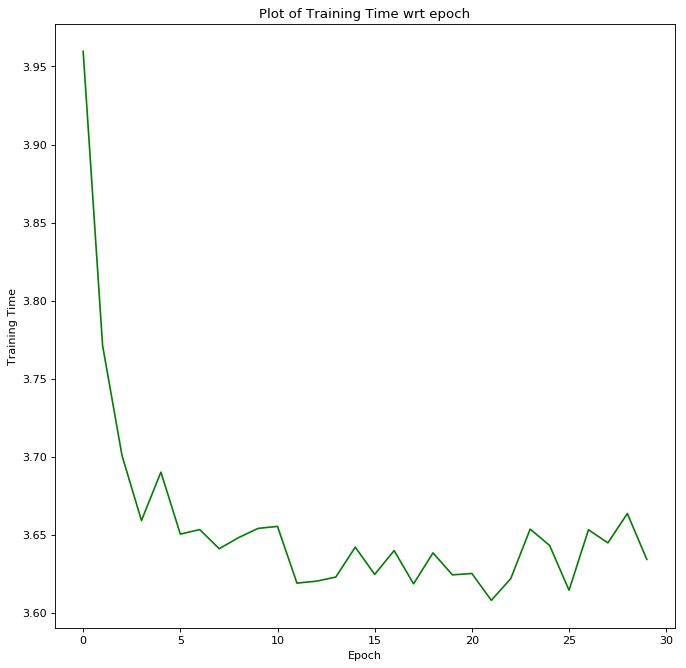

In [61]:
plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in time_taken], color='green')
plt.title("Plot of Training Time wrt epoch")
plt.ylabel("Training Time")
plt.xlabel("Epoch")
plt.show()

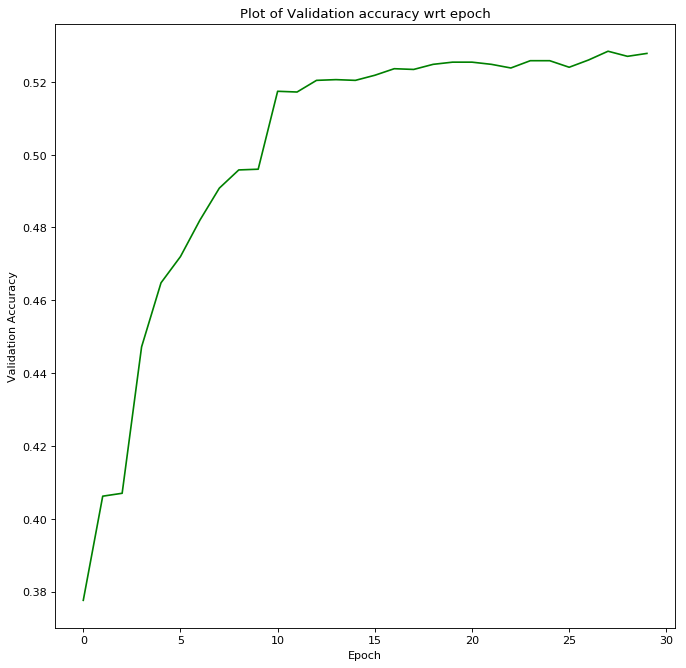

In [62]:
plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in val_accuracy], color='green')
plt.title("Plot of Validation accuracy wrt epoch")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epoch")
plt.show()

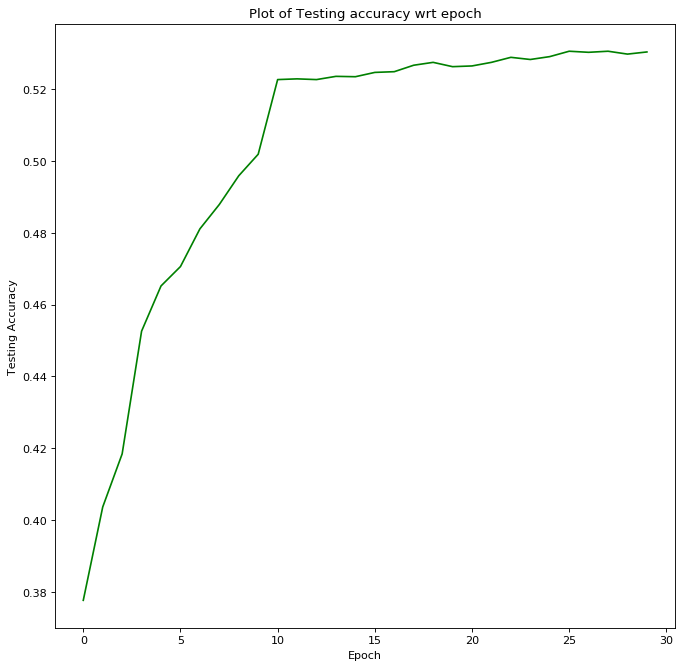

In [63]:
plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in test_accuracy], color='green')
plt.title("Plot of Testing accuracy wrt epoch")
plt.ylabel("Testing Accuracy")
plt.xlabel("Epoch")
plt.show()

# TRAINING PROCEDURE

* batch size of 128

* learning rate scheduler - 0.001 for first 10 epochs then 0.0001

* 2 hidden layers of dimension - 1000, 100 followed by output layer of dimension 10

* ReLU activation used for hidden layers, softmax for last output layer

* cross entropy loss used

* Adam optimizer used with beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8

* truncated normal initialization used for weights with mean of 0.0 and standard deviation of 1/sqrt(no of neurons in the layer)

# INSIGHTS

* After 11th epoch, the test accuracy gets saturated around 52% which could be attributed to the limited capacity of the network.

* The training time is mostly constant for each epoch
